In [11]:
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random

Using TensorFlow backend.


In [159]:
np.random.seed(1234)

# Global hyper-parameters
sequence_length = 100
random_data_dup = 10  # each sample randomly duplicated between 0 and 9 times, see dropin function
epochs = 5
batch_size = 50

In [162]:
csv_path = '/home/luohuifen/anomaly-detection/data/itraffic_data_per_hourly.csv'
col_names = ['Time', 'ISP'] # key 
csv_data = pd.read_csv(csv_path, header=0, names=col_names)
df = pd.DataFrame(csv_data)
print len(df)
#print df

1231


In [163]:
def dropin(X, y):
    """ The name suggests the inverse of dropout, i.e. adding more samples. See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)


def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise
    :return: the final wave
    """
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = int(round(0.8 * len(t)))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    return wave1 + wave2


def z_norm(result):
    """ Normalization function   
    :param result: data
    :return: normalized data
    """ 
    
    result = result.astype(np.float32) # convert its dtype from int64 to float32 in order to prevent numberic range
    result_mean = np.mean(result, dtype=np.float32)
    result_std = np.std(result, dtype=np.float32, ddof=1) # parameter ddof is set to 1
    result -= result_mean
    result = np.divide(result, result_std, dtype=np.float32)
    return result, result_mean


def get_split_prep_data(data, train_start, train_end, test_start, test_end):
    #data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print "\n Creating train data..."

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)
        
    print "Mean of train data : ", result_mean
    print "Train data shape  : ", result.shape
    train = result[train_start:train_end, :]
    
    
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_train, y_train = dropin(X_train, y_train)
    
    # test data
    print "\n Creating test data..."

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)
    

    print "Mean of test data : ", result_mean
    print "Test data shape  : ", result.shape

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model


In [164]:
def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print 'Generating data... '
        data = gen_wave()
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train, X_test, y_test = get_split_prep_data(data, 0, 700, 500, 1000)
    else:
        print 'Loading data...'
        X_train, y_train, X_test, y_test = get_split_prep_data(data, 0, 1000, 1000, 1230)

    print '\nData Loaded. Compiling...\n'

    if model is None:
        model = build_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print 'Training duration (s) : ', time.time() - global_start_time
        return model, y_test, 0

    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print str(e)
    print 'Training duration (s) : ', time.time() - global_start_time

    #return model, y_test, predicted
    return X_train, y_train, X_test, y_test, model, predicted

In [ ]:
X_train, y_train, X_test, y_test, model, y_predicted = run_network(data=df['ISP'])

Loading data...
('Length of Data', 1231)

 Creating train data...
Mean of train data :  4.54883e+10
Train data shape  :  (900, 100)
('X shape:', (900, 99))
('y shape:', (900,))

 Creating test data...
Mean of test data :  4.10843e+10
Test data shape  :  (130, 100)
('Shape X_train', (4591, 99))
('Shape X_test', (130, 99))

Data Loaded. Compiling...



/home/luohuifen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  del sys.path[0]
/home/luohuifen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/luohuifen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=64, return_sequences=True, input_shape=(99, 1))`
/home/luohuifen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:122: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


Compilation Time :  0.013279914856
Training...
Train on 4361 samples, validate on 230 samples
Epoch 1/5
4361/4361 [==============================] - 82s - loss: 0.2738 - val_loss: 0.1246
Epoch 2/5
4361/4361 [==============================] - 81s - loss: 0.0986 - val_loss: 0.1104
Epoch 3/5
4361/4361 [==============================] - 73s - loss: 0.0732 - val_loss: 0.0912
Epoch 4/5
4361/4361 [==============================] - 76s - loss: 0.0549 - val_loss: 0.0607
Epoch 5/5
4350/4361 [============================>.] - ETA: 0s - loss: 0.0467

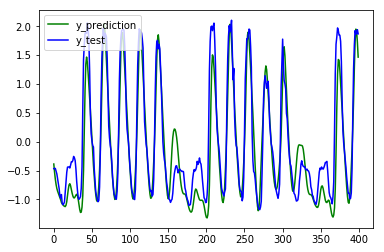

In [158]:
plt.plot(predicted, color='green', label='y_prediction')
plt.plot(y_test, color='blue', label='y_test')
plt.legend(loc='upper left')
plt.show()